In [1]:
# importing libraries 
import json
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# creating mask

def create_mask(image_shape, shape_attributes):
    mask = np.zeros(image_shape, dtype=np.uint8)
    
    if shape_attributes['name'] == 'polygon':
        points_x = shape_attributes['all_points_x']
        points_y = shape_attributes['all_points_y']
        points = np.array(list(zip(points_x, points_y)), dtype=np.int32)
        cv2.fillPoly(mask, [points], 1)
    
    elif shape_attributes['name'] == 'ellipse':
        center_x = int(shape_attributes['cx'])
        center_y = int(shape_attributes['cy'])
        radius_x = int(shape_attributes['rx'])
        radius_y = int(shape_attributes['ry'])
        angle = shape_attributes.get('theta', 0) * (180.0 / np.pi)  # Convert radians to degrees
        cv2.ellipse(mask, (center_x, center_y), (radius_x, radius_y), angle, 0, 360, 1, -1)
    
    return mask

In [3]:
import matplotlib.image as mpimg
img = mpimg.imread('VAL/y500.jpg')
img.shape


(351, 278, 3)

In [4]:
class BrainTumorDataset(Dataset):
    def __init__(self, json_file, root_dir, image_transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        
        try:
            with open(json_file) as f:
                self.data = json.load(f)
        except FileNotFoundError:
            raise FileNotFoundError(f"JSON file '{json_file}' not found.")

        # Assume all data belongs to TRAIN folder
        self.image_keys = list(self.data.keys())
        print(f"Loaded {len(self.image_keys)} entries from JSON file.")
        
    def __len__(self):
        return len(self.image_keys)

    def __getitem__(self, idx):
        image_key = self.image_keys[idx]
        image_info = self.data[image_key]

        file_name = image_info['filename']
        file_path = os.path.join(self.root_dir, file_name)

        try:
            image = Image.open(file_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image '{file_name}': {e}")
            return None

        original_size = image.size  # (width, height)

        regions = image_info['regions']
        mask = np.zeros((original_size[1], original_size[0]), dtype=np.uint8)  # Initialize mask with zeros

        for region in regions:
            shape_attributes = region['shape_attributes']
            mask = np.maximum(mask, create_mask((original_size[1], original_size[0]), shape_attributes))

        mask = Image.fromarray(mask)

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = transforms.ToTensor()(mask)

        return image, mask

In [5]:
# Define transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])

In [6]:
# Path to the JSON file containing annotations
root_dir = 'TRAIN'
json_file_path = os.path.join(root_dir, "annotations_train.json")

# Create dataset and dataloader for training using data from the TRAIN folder
train_dataset = BrainTumorDataset(json_file_path, root_dir, image_transform=image_transform, mask_transform=mask_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Debugging the data loading process
for i, data in enumerate(train_dataloader):
    if data is not None:
        images, masks = data
        if images is None or masks is None:
            continue  
        print(f"Batch {i}: Images shape: {images.shape}, Masks shape: {masks.shape}")

Loaded 500 entries from JSON file.
Batch 0: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 1: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 2: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 3: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 4: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 5: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 6: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 7: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 8: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 9: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 10: Image

In [7]:
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

C:\Users\Amlan Anupam\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Amlan Anupam\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [9]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# def visualize_raw_output(image, output):
#     image_np = image.cpu().numpy().transpose(1, 2, 0)
#     output_np = output.cpu().detach().numpy().squeeze()

#     plt.figure(figsize=(10, 5))

#     plt.subplot(1, 2, 1)
#     plt.title('Image')
#     plt.imshow(image_np)

#     plt.subplot(1, 2, 2)
#     plt.title('Raw Model Output')
#     plt.imshow(output_np, cmap='gray')

#     plt.show()

In [22]:
import torch.nn.functional as F

# Define Dice loss
def dice_loss(pred, target, smooth=1.0):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)

    return 1 - dice.mean()

# Combined BCE and Dice loss
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()

    def forward(self, pred, target):
        bce = F.binary_cross_entropy_with_logits(pred, target)
        pred = torch.sigmoid(pred)
        dice = dice_loss(pred, target)
        return bce + dice

In [26]:
# Training loop with improved loss function
criterion = BCEDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 30
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_dataloader:
        if data is None:
            continue
        images, masks = data
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)['out']
        
        # Compute loss
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader)}")

Epoch [1/30], Loss: 0.8779072751998901
Epoch [2/30], Loss: 0.8776019620895386
Epoch [3/30], Loss: 0.8774711666107178
Epoch [4/30], Loss: 0.8773568382263184
Epoch [5/30], Loss: 0.8773595938682556
Epoch [6/30], Loss: 0.8772602877616882
Epoch [7/30], Loss: 0.877300407409668
Epoch [8/30], Loss: 0.8771878809928894
Epoch [9/30], Loss: 0.8772155861854554
Epoch [10/30], Loss: 0.877210117816925
Epoch [11/30], Loss: 0.8772710547447204
Epoch [12/30], Loss: 0.8778288049697875
Epoch [13/30], Loss: 0.8773667368888854
Epoch [14/30], Loss: 0.8773583035469055
Epoch [15/30], Loss: 0.8772816567420959
Epoch [16/30], Loss: 0.8773034348487854
Epoch [17/30], Loss: 0.8772516059875488
Epoch [18/30], Loss: 0.8772431783676148
Epoch [19/30], Loss: 0.8772521634101867
Epoch [20/30], Loss: 0.8772385897636413
Epoch [21/30], Loss: 0.8772772121429443
Epoch [22/30], Loss: 0.8771945352554321
Epoch [23/30], Loss: 0.8771341328620911
Epoch [24/30], Loss: 0.8771788630485534
Epoch [25/30], Loss: 0.8772399468421936
Epoch [26/3

In [27]:
# Save the model
torch.save(model.state_dict(), 'segmentation_resnet50.pth')

In [28]:
# # Function to visualize the result
# def visualize_result(image, mask):
#     image_np = image.cpu().numpy().transpose(1, 2, 0)
#     mask_np = mask.cpu().numpy().squeeze()

#     plt.figure(figsize=(10, 5))

#     plt.subplot(1, 2, 1)
#     plt.title('Original Image')
#     plt.imshow(image_np)

#     plt.subplot(1, 2, 2)
#     plt.title('Predicted Mask')
#     plt.imshow(mask_np, cmap='gray')

#     plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


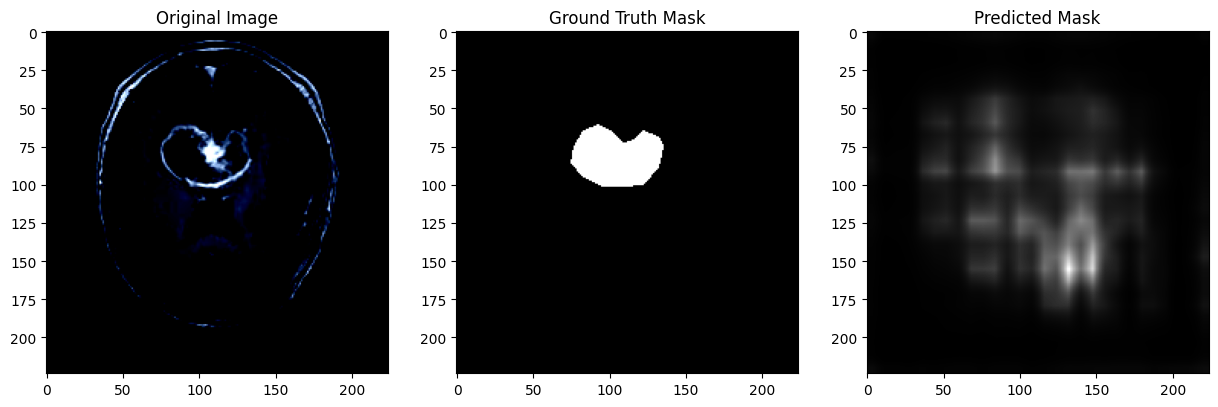

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


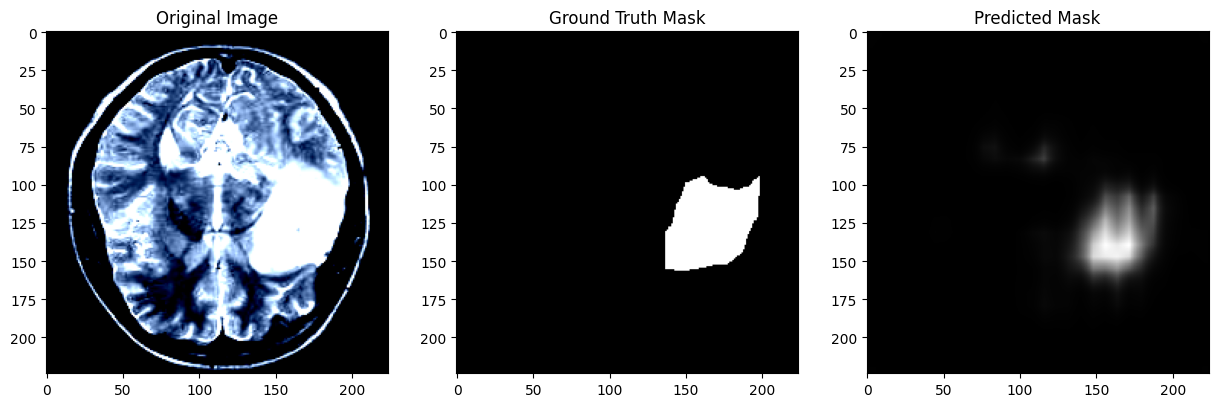

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


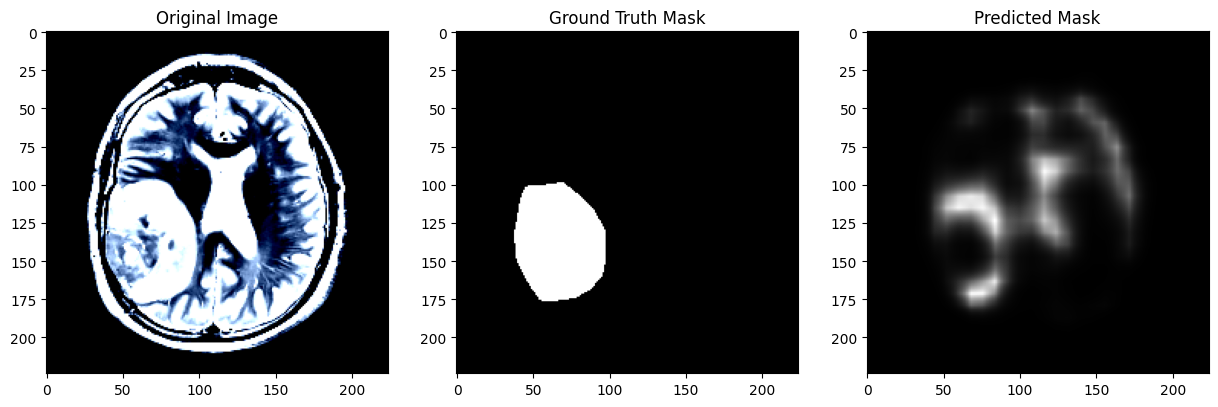

Average IoU for the training set: 1.0000


In [29]:
import torch
import matplotlib.pyplot as plt

def calculate_iou(preds, masks, threshold=0.5):
    preds = preds > threshold
    masks = masks > threshold  # Ensure masks are binary
    intersection = (preds & masks).float().sum((1, 2))  # Intersection area
    union = (preds | masks).float().sum((1, 2))        # Union area
    iou = (intersection + 1e-6) / (union + 1e-6)       # IoU calculation
    return iou.mean().item()

def visualize_result(image, mask, pred):
    image_np = image.cpu().numpy().transpose(1, 2, 0)
    mask_np = mask.cpu().numpy().squeeze()
    pred_np = pred.cpu().numpy().squeeze()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image_np)

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(mask_np, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(pred_np, cmap='gray')

    plt.show()

# Calculate IoU and visualize results
iou_scores = []

with torch.no_grad():
    model.eval()
    for images, masks in train_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        # Get model predictions
        outputs = model(images)['out']
        preds = torch.sigmoid(outputs)

        # Calculate IoU for each batch
        for i in range(len(images)):
            iou = calculate_iou(preds[i], masks[i])
            iou_scores.append(iou)

        # Visualize the first image and its mask from the batch
        visualize_result(images[0], masks[0], preds[0])
        visualize_result(images[1], masks[1], preds[1])
        visualize_result(images[2], masks[2], preds[2])
        break

# Calculate the average IoU for the entire training set
average_iou = sum(iou_scores) / len(iou_scores)
print(f"Average IoU for the training set: {average_iou:.4f}")

In [30]:
# Path to the JSON file containing annotations for the validation set
val_root_dir = 'VAL'
val_json_file_path = os.path.join(val_root_dir, "annotations_val.json")

# Create dataset and dataloader for validation using data from the VAL folder
val_dataset = BrainTumorDataset(val_json_file_path, val_root_dir, image_transform=image_transform, mask_transform=mask_transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)  

# Debugging the validation data loading process
for i, data in enumerate(val_loader):
    if data is not None:
        images, masks = data
        if images is None or masks is None:
            continue  
        print(f"Batch {i}: Images shape: {images.shape}, Masks shape: {masks.shape}")


Loaded 201 entries from JSON file.
Batch 0: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 1: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 2: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 3: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 4: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 5: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 6: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 7: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 8: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 9: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 10: Image

In [34]:
# Function to visualize images
def visualize_images(image, mask, prediction):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Convert tensors to numpy arrays and remove batch dimension
    image = image.squeeze().permute(1, 2, 0).cpu().numpy()
    mask = mask.squeeze().cpu().numpy()
    prediction = prediction.squeeze().cpu().numpy()

    # Visualize original image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Visualize mask
    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    # Visualize prediction
    axes[2].imshow(prediction, cmap="gray")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Average IoU for the validation set: 1.0000


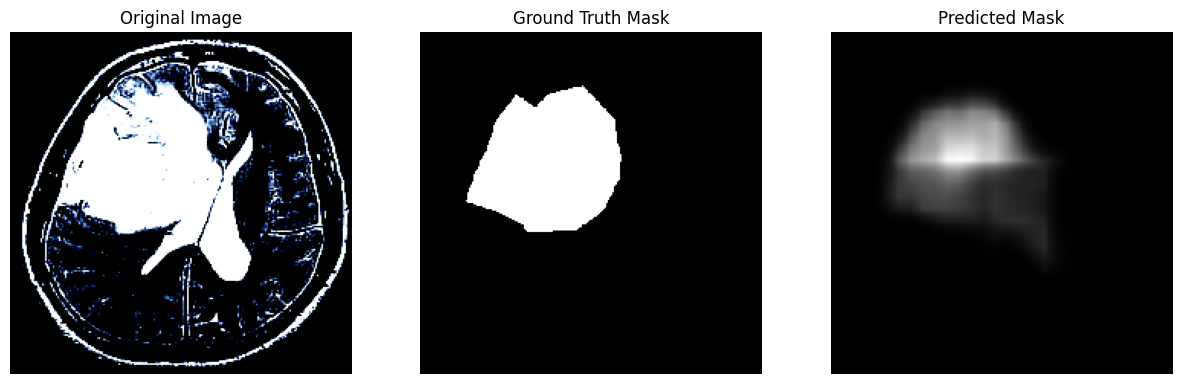

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


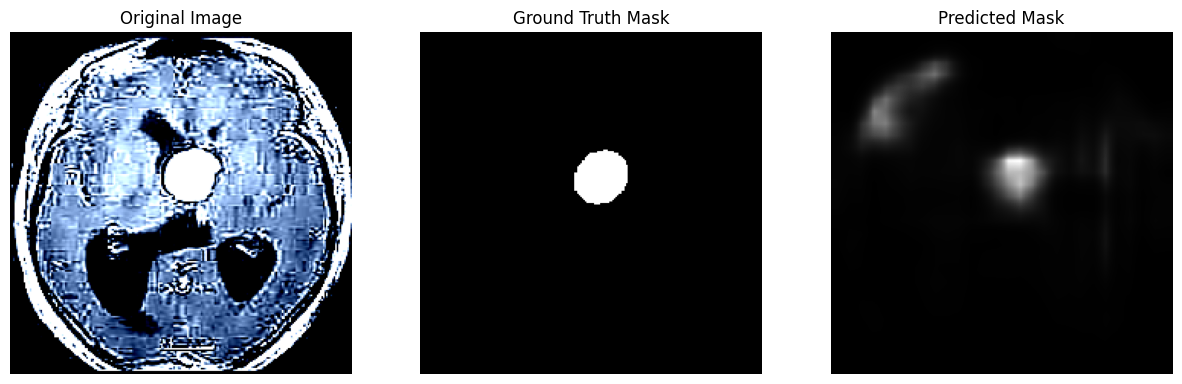

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


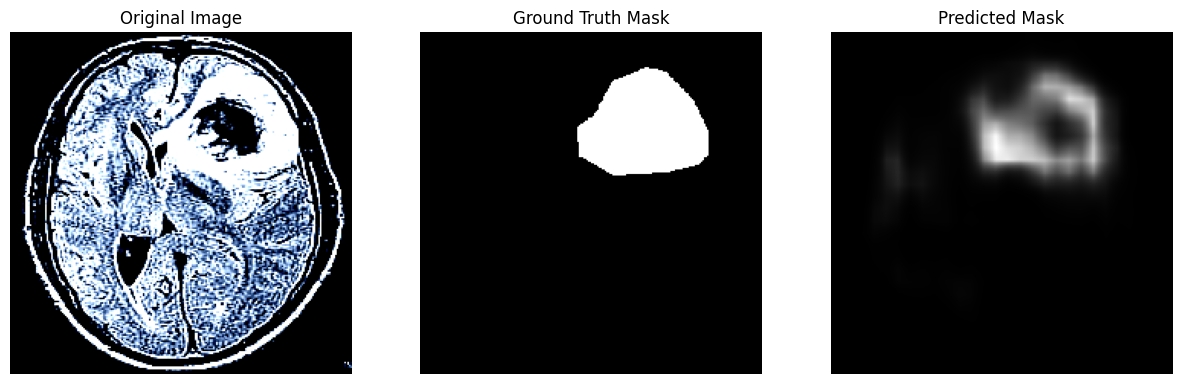

In [36]:
# Test the model and calculate IoU for the validation set
iou_scores = []

with torch.no_grad():
    model.eval()
    for images, masks in val_loader:
        # Move images and masks to device (GPU if available)
        images = images.to(device)
        masks = masks.to(device)

        # Get model predictions
        outputs = model(images)
        predictions = torch.sigmoid(outputs['out'])  # Adjust key based on your model's output

        # Calculate IoU for each batch
        for i in range(len(images)):
            iou = calculate_iou(predictions[i], masks[i])
            iou_scores.append(iou)

# Calculate the average IoU for the entire validation set
average_iou = sum(iou_scores) / len(iou_scores)
print(f"Average IoU for the validation set: {average_iou:.4f}")

# Visualize some images from the validation set
num_images_to_visualize = 3

with torch.no_grad():
    model.eval()
    for i, (image, mask) in enumerate(val_loader):
        if i >= num_images_to_visualize:
            break

        # Move images to device (GPU if available)
        image = image.to(device)

        # Get model predictions
        outputs = model(image)
        prediction = torch.sigmoid(outputs['out'])  # Adjust key based on your model's output

        # Visualize the images
        visualize_images(image[0], mask[0], prediction[0])  


In [37]:
# Path to the JSON file containing annotations for the test set
test_root_dir = 'TEST'
test_json_file_path = os.path.join(test_root_dir, "annotations_test.json")

# Create dataset and dataloader for the test set
test_dataset = BrainTumorDataset(test_json_file_path, test_root_dir, image_transform=image_transform, mask_transform=mask_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Use batch size of 1 for testing


# Debugging the test data loading process
for i, data in enumerate(test_loader):
    if data is not None:
        images, masks = data
        if images is None or masks is None:
            continue  
        print(f"Batch {i}: Images shape: {images.shape}, Masks shape: {masks.shape}")


Loaded 100 entries from JSON file.
Batch 0: Images shape: torch.Size([1, 3, 224, 224]), Masks shape: torch.Size([1, 1, 224, 224])
Batch 1: Images shape: torch.Size([1, 3, 224, 224]), Masks shape: torch.Size([1, 1, 224, 224])
Batch 2: Images shape: torch.Size([1, 3, 224, 224]), Masks shape: torch.Size([1, 1, 224, 224])
Batch 3: Images shape: torch.Size([1, 3, 224, 224]), Masks shape: torch.Size([1, 1, 224, 224])
Batch 4: Images shape: torch.Size([1, 3, 224, 224]), Masks shape: torch.Size([1, 1, 224, 224])
Batch 5: Images shape: torch.Size([1, 3, 224, 224]), Masks shape: torch.Size([1, 1, 224, 224])
Batch 6: Images shape: torch.Size([1, 3, 224, 224]), Masks shape: torch.Size([1, 1, 224, 224])
Batch 7: Images shape: torch.Size([1, 3, 224, 224]), Masks shape: torch.Size([1, 1, 224, 224])
Batch 8: Images shape: torch.Size([1, 3, 224, 224]), Masks shape: torch.Size([1, 1, 224, 224])
Batch 9: Images shape: torch.Size([1, 3, 224, 224]), Masks shape: torch.Size([1, 1, 224, 224])
Batch 10: Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Average IoU for the test set: 1.0000


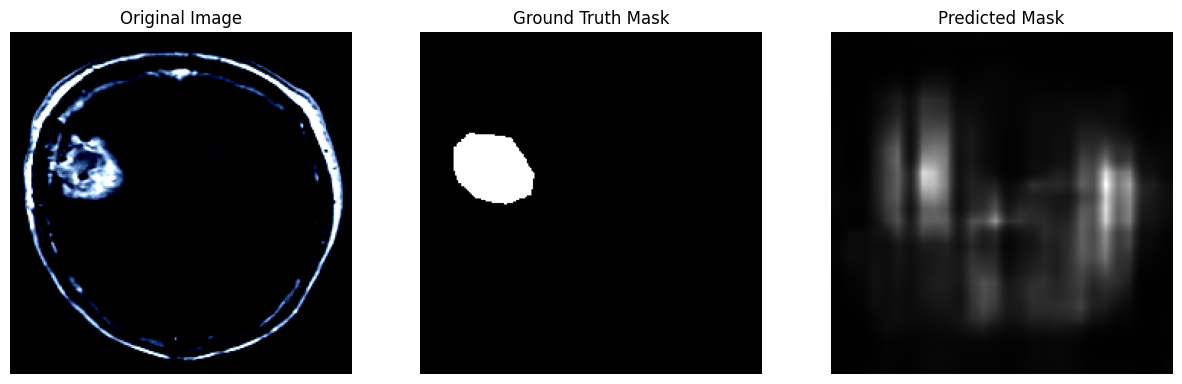

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


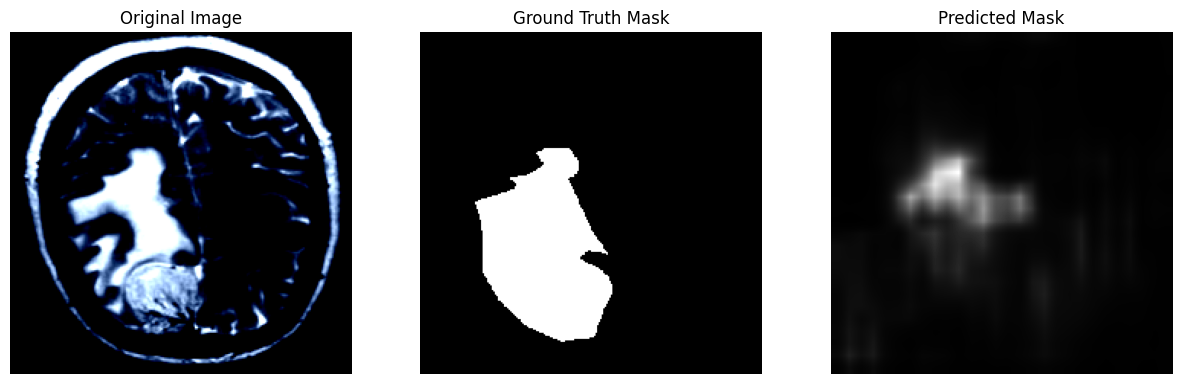

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


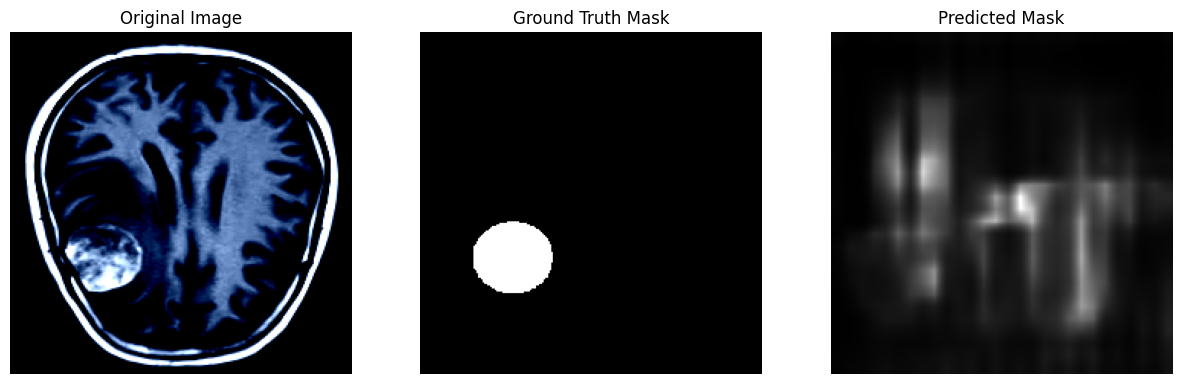

In [38]:
# Test the model and calculate IoU for the test set
iou_scores_test = []

with torch.no_grad():
    model.eval()
    for images, masks in test_loader:
        # Move images and masks to device (GPU if available)
        images = images.to(device)
        masks = masks.to(device)

        # Get model predictions
        outputs = model(images)
        predictions = torch.sigmoid(outputs['out'])  # Adjust key based on your model's output

        # Calculate IoU for each batch
        for i in range(len(images)):
            iou = calculate_iou(predictions[i], masks[i])
            iou_scores_test.append(iou)

# Calculate the average IoU for the entire test set
average_iou_test = sum(iou_scores_test) / len(iou_scores_test)
print(f"Average IoU for the test set: {average_iou_test:.4f}")

# Visualize some images from the test set
num_images_to_visualize_test = 3

with torch.no_grad():
    model.eval()
    for i, (image, mask) in enumerate(test_loader):
        if i >= num_images_to_visualize_test:
            break

        # Move images to device (GPU if available)
        image = image.to(device)

        # Get model predictions
        outputs = model(image)
        prediction = torch.sigmoid(outputs['out']) 
        # Visualize the images
        visualize_images(image[0], mask[0], prediction[0])  